In [1]:
# Import Packages and setup
import os
from functools import partial

import numpy as np
import scarlet
from scarlet.lite import integrated_circular_gaussian, LiteObservation, LiteSource, LiteBlend
from scarlet.lite import circular_gaussian, grad_circular_gaussian, sersic, grad_sersic
from scarlet.lite import CartesianFrame, ParametricComponent, bounded_prox, EllipticalParametricComponent
from scarlet.display import AsinhMapping, img_to_rgb
from scarlet.bbox import Box

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none', origin="lower")
prop_cycle = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

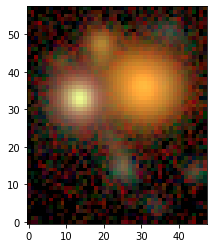

In [2]:
# Load the sample scarlet data (see https://pmelchior.github.io/scarlet/0-quickstart.html)
# for more on the dataset and how it is initialized
data = np.load(os.path.abspath(scarlet.__file__+"/../../data/hsc_cosmos_35.npz"))
images = data["images"]
variance = data["variance"]
weights = 1/variance
filters = data["filters"]
centers = [(src['y'], src['x']) for src in data["catalog"]] # Note: y/x convention!
psfs = data["psfs"]

ratio = images.shape[-2]/images.shape[-1]
model_psf = integrated_circular_gaussian(sigma=0.8)
observation = LiteObservation(images, variance, weights, psfs, model_psf[None, :, :])

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(rgb)
plt.show()

/Users/fred3m/projects/scarlet/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in true_divide
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):
/Users/fred3m/projects/scarlet/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in greater
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):
/Users/fred3m/projects/scarlet/scarlet/lite/measure.py:85: RuntimeWarning: divide by zero encountered in true_divide
  ratio = numerator / denominator
/Users/fred3m/projects/scarlet/scarlet/lite/measure.py:85: RuntimeWarning: invalid value encountered in true_divide
  ratio = numerator / denominator


CPU times: user 2.15 s, sys: 39.9 ms, total: 2.19 s
Wall time: 853 ms


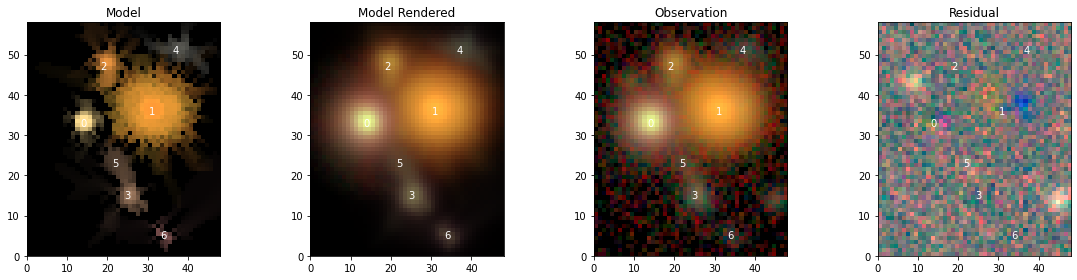

In [3]:
# This cell shows the results using the lsst_dev branch of scarlet.lite
# that is run in the Rubin LSST DM pipeline.
from scarlet.lite import init_all_sources_main

# Convert the coordinates into their integer positions
_centers = [[int(c[0]), int(c[1])] for c in centers]
# Initialize the sources and set them to use ADAPROX as their opimizer
sources = init_all_sources_main(observation, _centers)
parameterize = partial(scarlet.lite.init_adaprox_component, bg_thresh=0.25, max_prox_iter=1)
sources = scarlet.lite.parameterize_sources(sources, observation, parameterize)

blend = scarlet.lite.LiteBlend(sources, observation).fit_spectra()
%time blend.fit(100)
scarlet.lite.display.show_scene(blend, norm=norm, show_observed=True, show_rendered=True, show_residual=True, show_model=True)
plt.show()

CPU times: user 2.92 s, sys: 44.1 ms, total: 2.96 s
Wall time: 1.63 s


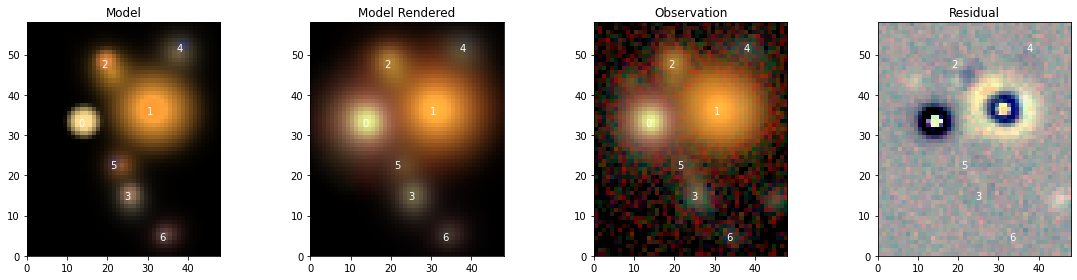

In [4]:
# Initialize the data frame that will hold the observations
frame = CartesianFrame(observation.bbox)
sources = []
sigma = 0.8
for idx, center in enumerate(centers):
    # Get the integer center of the source
    cy, cx = int(np.round(center[0])), int(np.round(center[1]))
    # Initialize the SED to the data at it's central location
    sed = observation.data[:, cy, cx].copy()
    # For now we use a fixed bounding box that is the size of the observed PSF image
    bbox = Box((observation.bbox.shape[0], 41, 41), origin=(0, cy-20, cx-20))
    # Keep track of the initial positions
    yi, xi = cy, cx
    # Restrict the values of the parameters
    _proxmin = np.array([yi-2, xi-2, 1e-1, 1e-1, -np.pi/2, 1])
    _proxmax = np.array([yi+2, xi+2, frame.shape[-2]/2, frame.shape[-1]/2, np.pi/2, 1])
    
    # Initialize a PSF-like component of the source using a non-pixel integrated gaussian
    component = ParametricComponent(
        sed=sed*.8,
        morph_params=np.array([center[0], center[1]]),
        morph_func=partial(circular_gaussian, sigma=0.8),
        morph_grad=partial(grad_circular_gaussian, sigma=0.8),
        morph_prox=partial(bounded_prox, proxmin=_proxmin[:2], proxmax=_proxmax[:2]),
        morph_step=np.array([1e-2, 1e-2]),
        bbox=bbox,
        model_frame=frame,
    )
    # Define the component to use ADAPROX as the optimizer
    component.init_adaprox(observation.noise_rms)
    components = [component]

    # Initialize an n=1 sersic component
    component = EllipticalParametricComponent(
        sed=sed/3,
        morph_params=np.array([center[0], center[1], 2*1.2**2, 2*1.2**2, 0.0, 1]),
        morph_func=sersic,
        morph_grad=grad_sersic,
        morph_prox=partial(bounded_prox, proxmin=_proxmin, proxmax=_proxmax),
        morph_step=np.array([1e-2, 1e-2, 1e-3, 1e-3, 1e-2, 1e-2]),
        bbox=bbox,
        model_frame=frame,
    )
    # Define the component to use ADAPROX as the optimizer
    component.init_adaprox(observation.noise_rms)
    components.append(component)
    # Create a new source using the two components
    sources.append(LiteSource(components, dtype=observation.dtype))

# Fit the models
blend = LiteBlend(sources, observation).fit_spectra()
%time blend.fit(100)

# Display the models, observations, and data-model residual
scarlet.lite.display.show_scene(blend, norm=norm, show_observed=True, show_rendered=True, show_residual=True, show_model=True)
plt.show()

CPU times: user 3.01 s, sys: 42.4 ms, total: 3.06 s
Wall time: 1.72 s


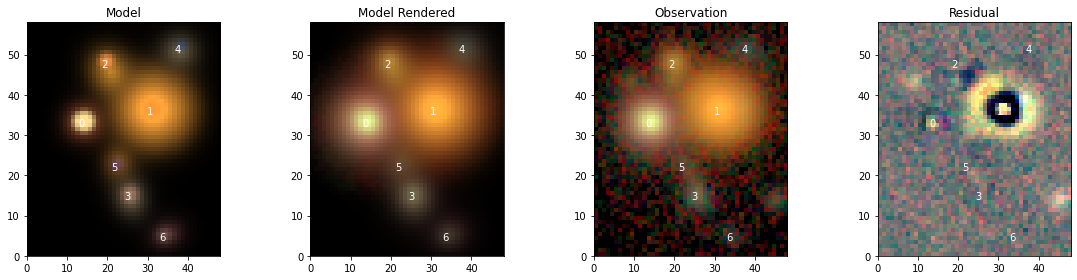

In [5]:
# This cell tests using an integrated Gaussian as opposed to a
# non-integrated Gaussian for the 1st component

from scarlet.lite import integrated_gaussian, grad_integrated_gaussian
# Initialize the data frame that will hold the observations
frame = CartesianFrame(observation.bbox)
sources = []
sigma = 0.8
for idx, center in enumerate(centers):
    # Get the integer center of the source
    cy, cx = int(np.round(center[0])), int(np.round(center[1]))
    # Initialize the SED to the data at it's central location
    sed = observation.data[:, cy, cx].copy()
    # For now we use a fixed bounding box that is the size of the observed PSF image
    bbox = Box((observation.bbox.shape[0], 41, 41), origin=(0, cy-20, cx-20))
    # Keep track of the initial positions
    yi, xi = cy, cx
    # Restrict the values of the sersic parameters
    _proxmin = np.array([yi-2, xi-2, 1e-1, 1e-1, -np.pi/2, 1])
    _proxmax = np.array([yi+2, xi+2, frame.shape[-2]/2, frame.shape[-1]/2, np.pi/2, 1])
    # Restrict the values of the PSF parameters
    __proxmin = np.array([yi-2, xi-2, 0.8])
    __proxmax = np.array([yi+2, xi+2, 1.2])
    
    # Initialize a PSF-like component of the source using a pixel integrated gaussian
    component = ParametricComponent(
        sed=sed*.8,
        morph_params=np.array([center[0], center[1], 0.8]),
        morph_func=integrated_gaussian,
        morph_grad=grad_integrated_gaussian,
        morph_prox=partial(bounded_prox, proxmin=__proxmin, proxmax=__proxmax),
        morph_step=np.array([1e-2, 1e-2, 1e-2]),
        bbox=bbox,
        model_frame=frame,
    )
    # Define the component to use ADAPROX as the optimizer
    component.init_adaprox(observation.noise_rms)
    components = [component]

    # Initialize an n=1 sersic component
    component = EllipticalParametricComponent(
        sed=sed/3,
        morph_params=np.array([center[0], center[1], 2*1.2**2, 2*1.2**2, 0.0, 1]),
        morph_func=sersic,
        morph_grad=grad_sersic,
        morph_prox=partial(bounded_prox, proxmin=_proxmin, proxmax=_proxmax),
        morph_step=np.array([1e-2, 1e-2, 1e-3, 1e-3, 1e-2, 1e-2]),
        bbox=bbox,
        model_frame=frame,
    )
    # Define the component to use ADAPROX as the optimizer
    component.init_adaprox(observation.noise_rms)
    components.append(component)
    # Create a new source using the two components
    sources.append(LiteSource(components, dtype=observation.dtype))

# Fit the models
blend = LiteBlend(sources, observation).fit_spectra()
%time blend.fit(100)

# Display the models, observations, and data-model residual
scarlet.lite.display.show_scene(blend, norm=norm, show_observed=True, show_rendered=True, show_residual=True, show_model=True)
plt.show()

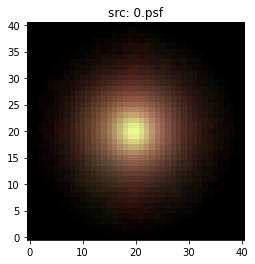

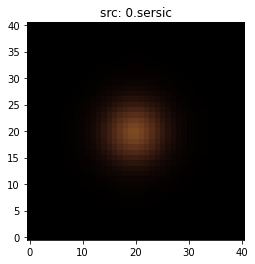

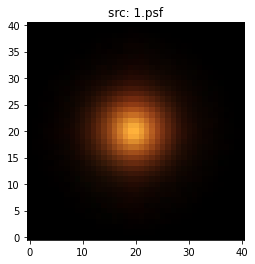

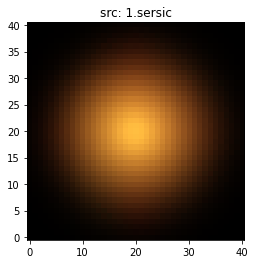

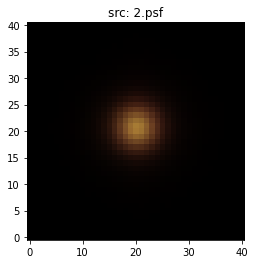

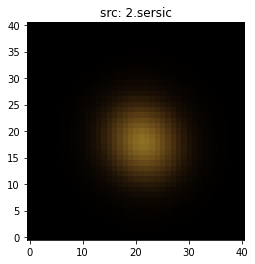

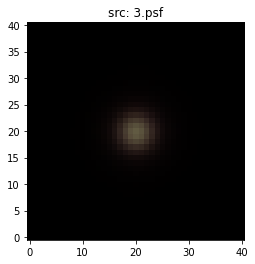

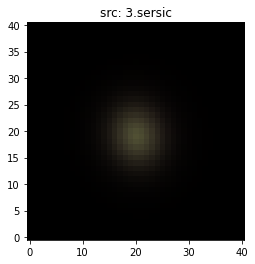

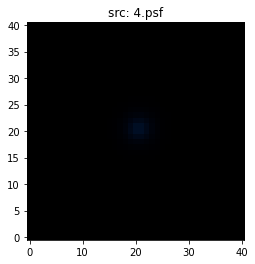

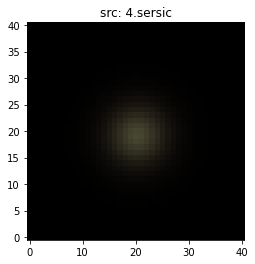

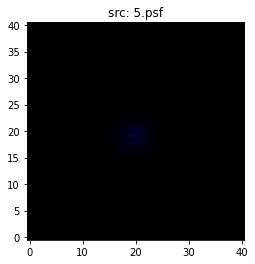

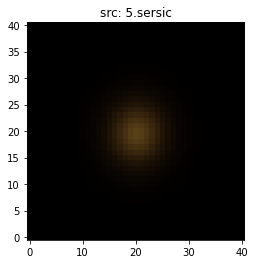

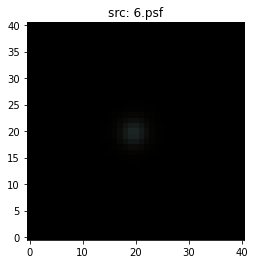

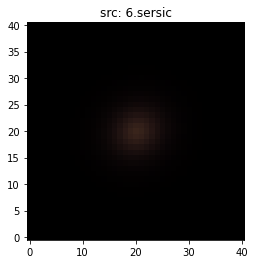

In [6]:
# Display the component models for all of the sources in the blend
ctypes = {0: "psf", 1: "sersic"}
for sidx, src in enumerate(blend.sources):
    for cidx, c in enumerate(src.components):
        model = observation.convolve(c.get_model())
        rgb = scarlet.display.img_to_rgb(model, norm=norm)
        plt.imshow(rgb)
        if len(src.components) == 1:
            plt.title(f"psf source {sidx}")
        else:
            plt.title(f"src: {sidx}.{ctypes[cidx]}")
        plt.show()